In [1]:
%matplotlib inline

In [2]:
import os
import glob

import numpy as np
import pylab as plt

import astra
import tomopy
# import cv2
from pprint import pprint
import h5py

import astra

In [3]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [4]:
def build_reconstruction_geomety(detector_size, angles):
#     proj_geom = astra.create_proj_geom('parallel', 1.0, detector_size, angles)   
    # proj_geom = astra.create_proj_geom('parallel', 1.0, detector_size, angles)
    
    #Object to Source (mm) = 56.135
    #Camera to Source (mm) = 225.082
    
    # All distances in [pixels]
#     pixel_size = 0.0001
#     os_distance = 9.99/pixel_size
#     ds_distance = 10./pixel_size
    
#     proj_geom = astra.create_proj_geom('fanflat', ds_distance/os_distance, detector_size, angles,
#                                        os_distance, (ds_distance-os_distance))
    proj_geom = astra.create_proj_geom('parallel', 1, detector_size, angles)
    
    return proj_geom
    return proj_geom

def astra_tomo2d(sinogram, angles):
    angles = angles.astype('float64') # hack for astra stability, may be removed in future releases
    detector_size = sinogram.shape[1]
    
    rec_size = detector_size# size of reconstruction region
    vol_geom = astra.create_vol_geom(rec_size, rec_size)

    proj_geom = build_reconstruction_geomety(detector_size, angles)
    
    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Set up the parameters for a reconstruction algorithm using the GPU
#     cfg = astra.astra_dict('CGLS_CUDA')
    cfg = astra.astra_dict('FBP_CUDA')

    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['option'] = {}
#     cfg['option']['ShortScan'] = True
#     cfg['option']['MinConstraint'] = 0
#     cfg['option']['MaxConstraint'] = 0.02

    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id, 100)
    # Get the result
    rec = astra.data2d.get(rec_id)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return rec, proj_geom, cfg

def astra_build_sinogram(rec, angles):
    angles = angles.astype('float64') # hack for astra stability, may be removed in future releases
    detector_size = rec.shape[1]
    
    rec_size = detector_size# size of reconstruction region
    vol_geom = astra.create_vol_geom(rec_size, rec_size)

    proj_geom = build_reconstruction_geomety(detector_size, angles)
    
    proj_id = astra.create_projector('cuda',proj_geom,vol_geom)
    sinogram_id, sinogram = astra.create_sino(rec, proj_id)
    
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return sinogram

In [5]:
from skimage.io import imread

In [35]:
sinogram = imread('/home/makov/diskmnt/big/tomo_data/bukreeva/data_ESRF/sino_ESRF.tif').astype('float32')[:-1,:]
sinogram -= sinogram.min()
sinogram *=1e14
# sinogram/=sinogram.max()
# sinogram = -np.log(sinogram)

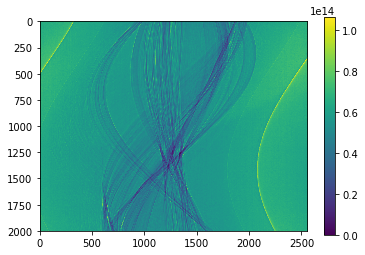

In [36]:
plt.imshow(sinogram)
plt.colorbar()

In [8]:
sinogram.shape

(2000, 2559)

In [9]:
np.percentile(sinogram,95)

12601745.149999999

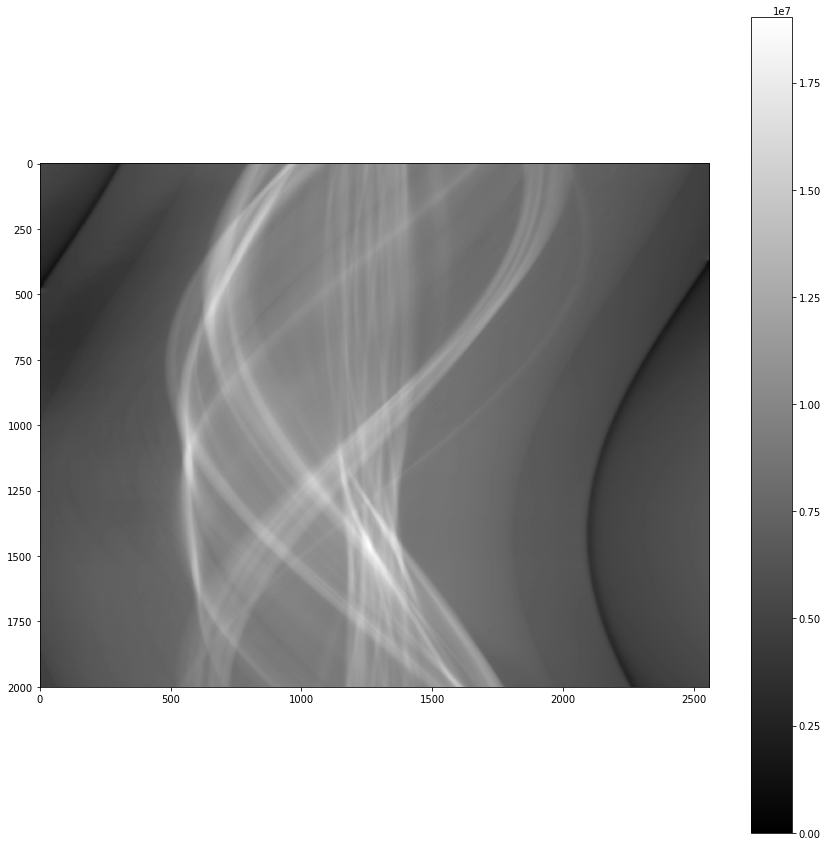

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(sinogram, cmap=plt.cm.gray, interpolation='nearest')
plt.colorbar()
plt.show()

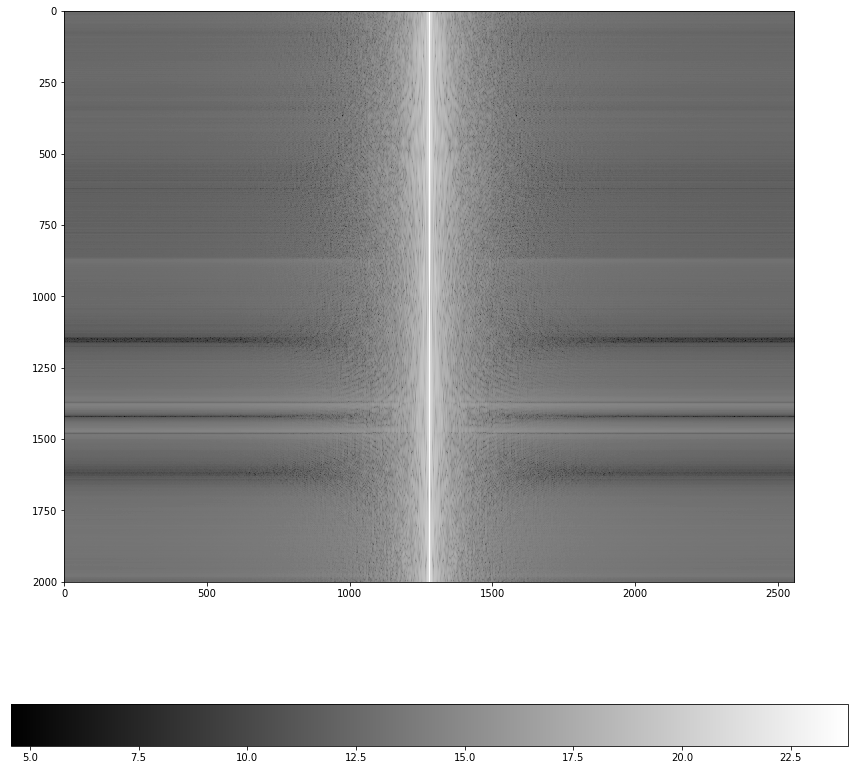

In [11]:
fs = np.fft.fft(sinogram)
fs = np.fft.fftshift(fs)
plt.figure(figsize=(15,15))
plt.imshow(np.log(np.abs(fs)), cmap=plt.cm.gray, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.show()

In [11]:
def get_cm(data):
    X,Y = np.meshgrid(range(data.shape[1]),range(data.shape[0]))
    m1 = data*X
    return m1.sum(axis=-1)/data.sum(axis=-1)

In [12]:
from scipy.optimize import curve_fit

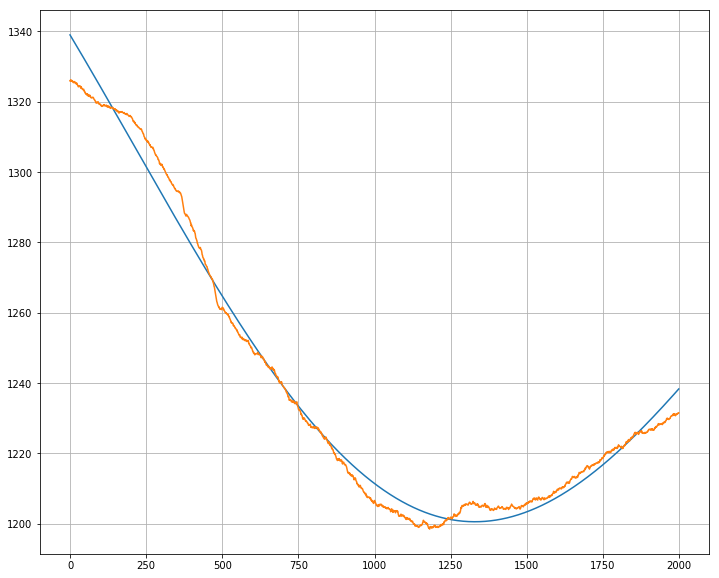

In [13]:
def f(x,a,b,phi,c):
    return a+b*np.sin((x/4000.+phi)*2*np.pi)+c*x

st = (sinogram.T/sinogram.mean(axis=1)).T
cm = get_cm(st)
x0 = np.arange(len(cm))
cm_fit = curve_fit(f, x0,cm)
plt.figure(figsize=(12,10))
y1 = f(x0, cm_fit[0][0],cm_fit[0][1],cm_fit[0][2],cm_fit[0][3])
dy = y1-cm
plt.plot(y1)
plt.plot(cm)
# plt.plot(dy)
plt.grid()
plt.show()

In [14]:
cm_fit[0]

array([  1.31230181e+03,  -8.17801586e+01,   4.94701705e+00,
        -2.35755232e-02])

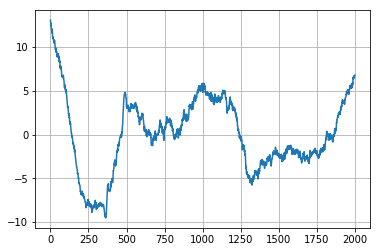

In [15]:
plt.plot(dy)
plt.grid()

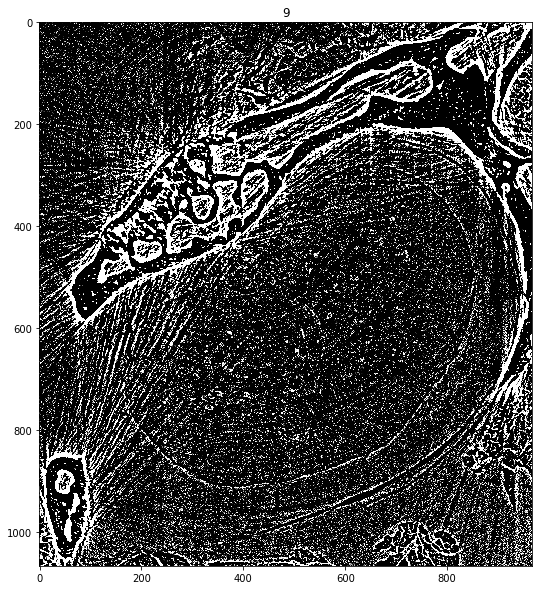

In [37]:
# plt.figure(figsize=(10,10))
# plt.imshow(sinogram_fixed, cmap=plt.cm.gray, interpolation='nearest')
# plt.colorbar(orientation='horizontal')
# plt.axis('tight')
# plt.show()
for shift in [9,]:

    pad_size =1024*2
    sinogram_fixed=np.zeros((sinogram.shape[0],sinogram.shape[1]+shift+pad_size*2),dtype='float32')
    angles = np.linspace(0,180, sinogram_fixed.shape[0],False)*np.pi/180
    mask=np.zeros_like(sinogram)
    sinogram_fixed[:,pad_size:-shift-pad_size] = (sinogram.T/sinogram.mean(axis=1)).T

#     st = (sinogram.T/sinogram.mean(axis=1)).T
#     st = sinogram/sinogram.mean().mean()
#     for i in range(sinogram_fixed.shape[0]):

#         shrink = int(dy[i])
#         srink = int(-8.*i/sinogram_fixed.shape[0])
#         if shrink > 0:
#         shrink = 0
#         sinogram_fixed[i,shrink+pad_size:shrink-shift-pad_size]  =  st[i]
        

    # step = 2
    # for i in bad_angles:
    #     sinogram_fixed[i[0]-step:i[0]+step] = 0.5*(
    #         sinogram_fixed[i[0]-step*3:i[0]-step]+sinogram_fixed[i[0]+step:i[0]+step*3])

    # sinogram_fixed[-1] = np.flipud(sinogram_fixed[0])

    rec, proj_geom, cfg = astra_tomo2d(sinogram_fixed, angles)

#     plt.figure(figsize=(15,5))
#     plt.plot(sinogram_fixed[0]-np.flipud(sinogram_fixed[-1]))
#     plt.plot(sinogram_fixed[0])
#     plt.plot(np.flipud(sinogram_fixed[-1]))

#     plt.grid()
#     plt.show()

#     plt.figure(figsize=(10,10))
#     # plt.imshow(rec,vmin=0.1, vmax=0.2)

#     plt.imshow(-rec,#[pad_size+1000:-pad_size-500,pad_size+900:-pad_size-700],
# #                vmin=-0.001, vmax=0.001,

#             interpolation='nearest', cmap=plt.cm.gray)
#     plt.colorbar(orientation='horizontal')
#     plt.title(shift)
#     plt.show()
    plt.figure(figsize=(10,10))
    # plt.imshow(rec,vmin=0.1, vmax=0.2)

    plt.imshow(rec[pad_size+1000:-pad_size-500,pad_size+900:-pad_size-700],
               vmin=4e-4, vmax=5.5e-4,

            interpolation='nearest', cmap=plt.cm.gray)
#     plt.colorbar(orientation='horizontal')
    plt.title(shift)
    plt.show()

In [32]:
sino_cut.shape

(1991, 2559)

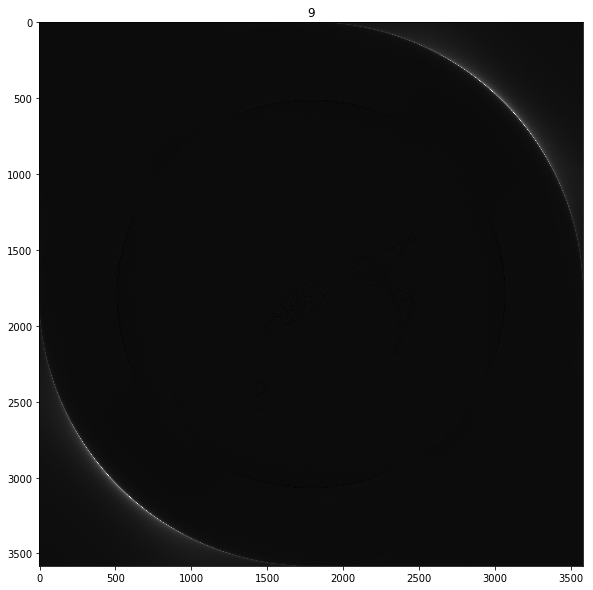

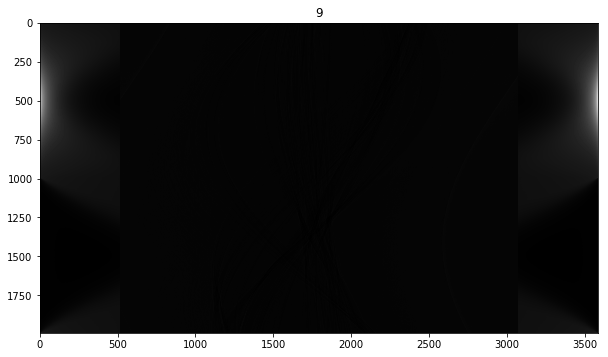

In [49]:

for shift in [9,]:

    padsize =512
    sinogram_cut=sinogram[:-shift]
    sino=np.zeros((sinogram_cut.shape[0],sinogram_cut.shape[1]+padsize*2),dtype='float32')
    angles = np.linspace(0,180, sino.shape[0],False)*np.pi/180
    sinogram_cut = (sinogram_cut.T/sinogram_cut.mean(axis=1)).T
#     sinogram_fixed[:,pad_size:-shift-pad_size] = (sinogram.T/sinogram.mean(axis=1)).T

#     rec, proj_geom, cfg = astra_tomo2d(sinogram_fixed, angles)
    sino[:,padsize:-padsize] = sinogram_cut
    rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)
    max_radon=sino.sum(axis=1).max()

    MU = rec.sum()*2
    X,Y = np.meshgrid(np.arange(rec_pad.shape[0]),np.arange(rec_pad.shape[1]))

    X-=rec_pad.shape[0]//2
    Y-=rec_pad.shape[1]//2

    mask = (X**2+Y**2)<(rec.shape[0]//2)**2-10

    for i in log_progress(range(100)):
        rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)
        rec_pad*=rec_pad>0
        rec_pad*=mask
        sino = astra_build_sinogram(rec_pad, angles)
        k = sino[:,padsize:-padsize].mean(axis=-1)/sinogram_cut.mean(axis=-1)
        if np.sum(np.argwhere(k==0))>0:
            break

        sino[:,padsize:-padsize] = sinogram_cut
        sino[:,0:padsize]=(sino[:,0:padsize].T/k).T
        sino[:,-padsize:]=(sino[:,-padsize:].T/k).T
        
        sino = (sino.T/sino.sum(axis=1)*sino.sum(axis=1).mean()).T
        sino[:,padsize:-padsize] = sinogram_cut

    rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)

    plt.figure(figsize=(10,10))
    # plt.imshow(rec,vmin=0.1, vmax=0.2)

    plt.imshow(rec_pad,#[pad_size+1000:-pad_size-500,pad_size+900:-pad_size-700],
#                vmin=4e-4, vmax=5.5e-4,

            interpolation='nearest', cmap=plt.cm.gray)
#     plt.colorbar(orientation='horizontal')
    plt.title(shift)
    plt.show()
    
    plt.figure(figsize=(10,10))
    # plt.imshow(rec,vmin=0.1, vmax=0.2)

    plt.imshow(sino,#[pad_size+1000:-pad_size-500,pad_size+900:-pad_size-700],
#                vmin=4e-4, vmax=5.5e-4,

            interpolation='nearest', cmap=plt.cm.gray)
#     plt.colorbar(orientation='horizontal')
    plt.title(shift)
    plt.show()

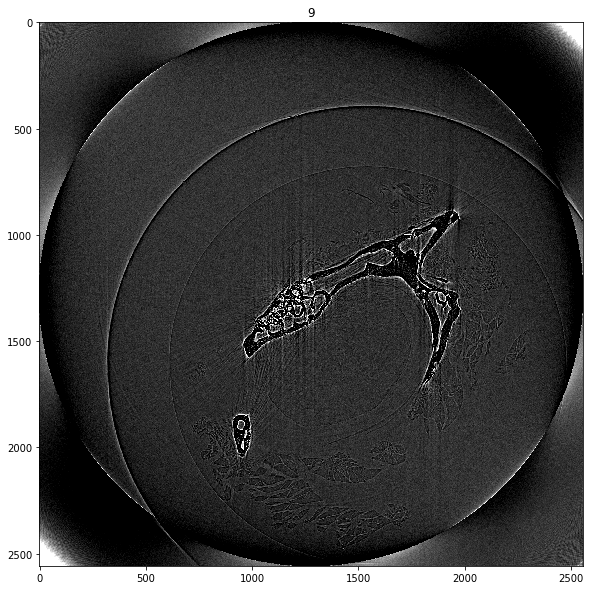

In [51]:
    plt.figure(figsize=(10,10))
    # plt.imshow(rec,vmin=0.1, vmax=0.2)

    plt.imshow(rec_pad[padsize:-padsize,padsize:-padsize],
               vmin=-1e-3, vmax=4.e-3,

            interpolation='nearest', cmap=plt.cm.gray)
#     plt.colorbar(orientation='horizontal')
    plt.title(shift)
    plt.show()

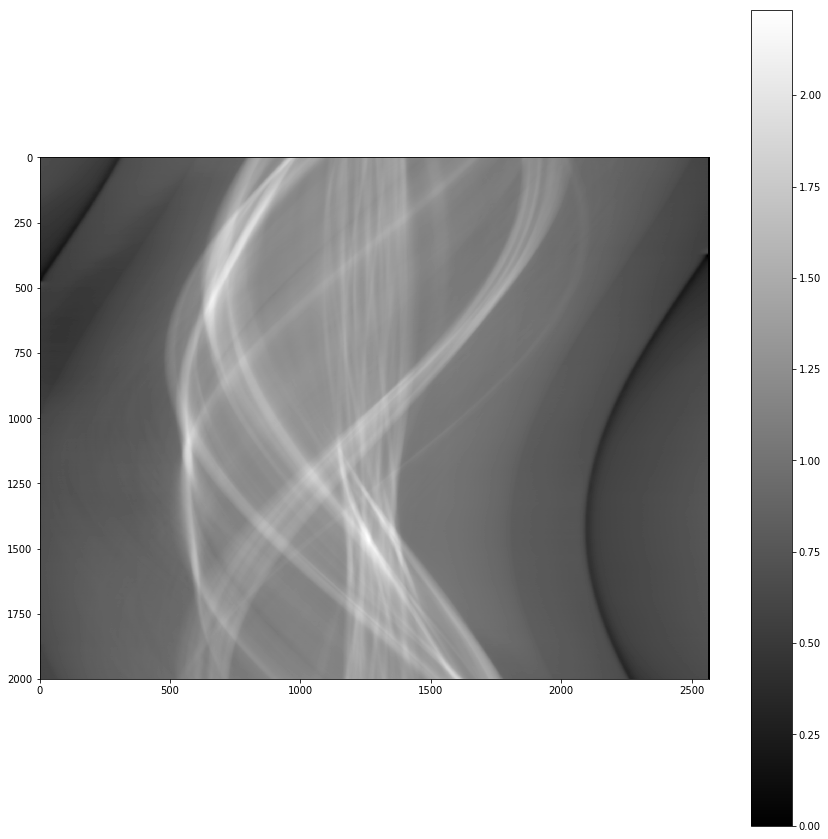

In [20]:
plt.figure(figsize=(15,15))
plt.imshow(sinogram_fixed[:,2048:-2048], cmap=plt.cm.gray, interpolation='nearest')
plt.colorbar()
plt.show()

In [23]:
np.save('/diskmnt/a/makov/tomo_data/bukreeva/data_ESRF/tmp/sino_esrf_fixed.npy',
           sinogram_fixed[:,2048:-2048])
np.save('/diskmnt/a/makov/tomo_data/bukreeva/data_ESRF/tmp/tomo_esrf_fixed.npy',
           rec[pad_size:-pad_size,pad_size:-pad_size])

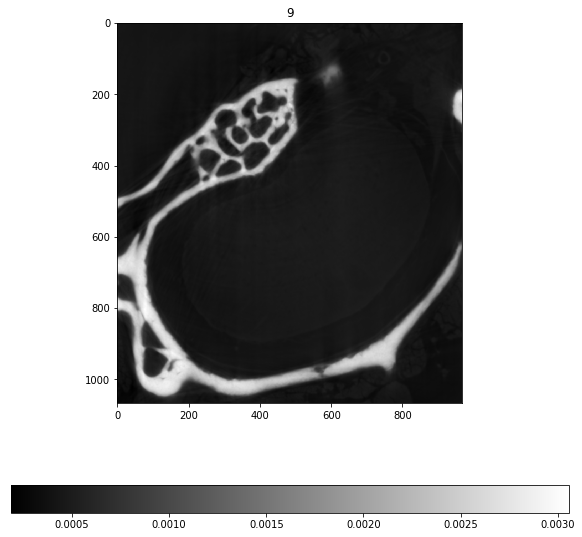

In [359]:
plt.figure(figsize=(10,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)

plt.imshow(rec[pad_size+1000:-pad_size-500,pad_size+900:-pad_size-700],
#            vmin=4e-4, vmax=5.5e-4,

        interpolation='nearest', cmap=plt.cm.gray)
plt.colorbar(orientation='horizontal')
plt.title(shift)
plt.show()

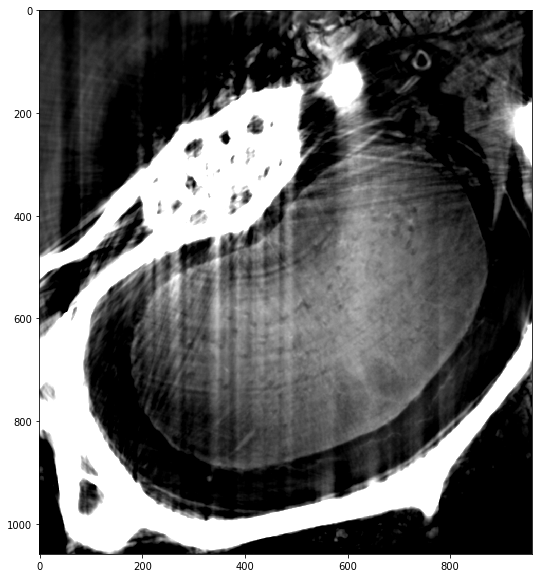

In [317]:
data = imread('/home/makov/diskmnt/big/tomo_data/bukreeva/data_ESRF/slice_Paganin.tif').astype('float32')*1e3
plt.figure(figsize=(10,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(data[1000:-500,900:-700], interpolation='nearest', 
           vmin=1.e-8, vmax=2.5e-8,
           cmap=plt.cm.gray)
# plt.colorbar(orientation='horizontal')
plt.show()

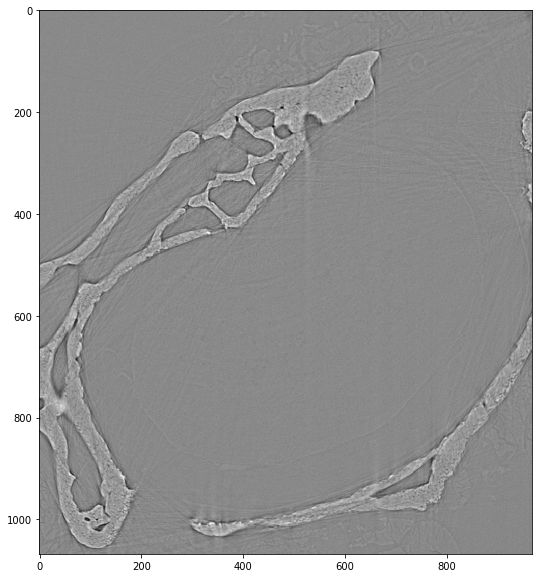

In [79]:

plt.figure(figsize=(10,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)

plt.imshow(-rec[pad_size+1000:-pad_size-500,pad_size+900:-pad_size-700],
#             vmin=-0.001, vmax=0.001,
       interpolation='nearest', cmap=plt.cm.gray)
# plt.colorbar(orientation='horizontal')
# plt.title(gamma)
plt.show()

In [21]:
sinogram.shape

(2000, 2559)

In [30]:
from skimage.transform import hough_line
from scipy.signal import medfilt

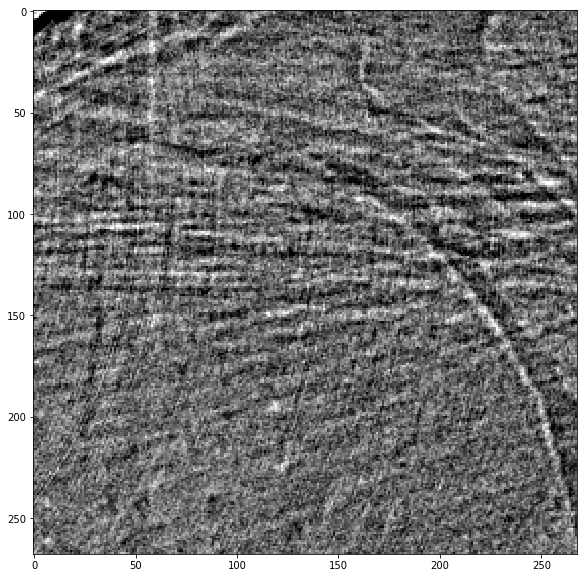

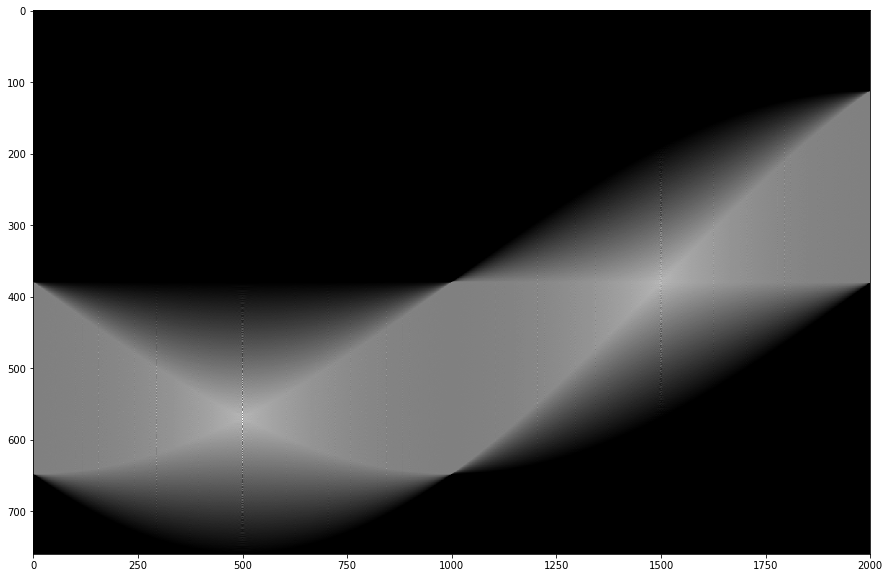

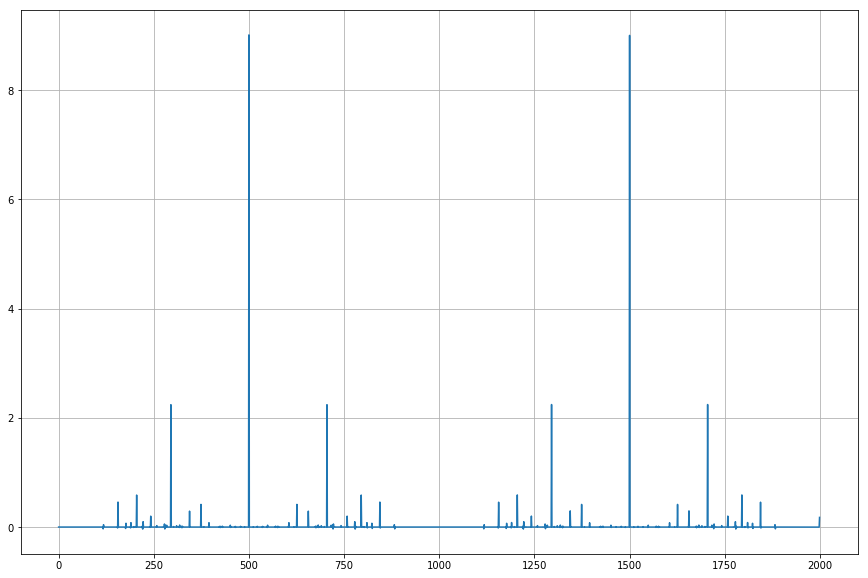

[[ 156]
 [ 205]
 [ 295]
 [ 344]
 [ 374]
 [ 500]
 [ 626]
 [ 656]
 [ 705]
 [ 795]
 [ 844]
 [1156]
 [1205]
 [1295]
 [1344]
 [1374]
 [1500]
 [1626]
 [1656]
 [1705]
 [1795]
 [1844]]


In [37]:
plt.figure(figsize=(10,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
d = -rec[pad_size+1000+200:-pad_size-500-600,pad_size+900+600:-pad_size-700-100]
# d=-rec
plt.imshow(d,
            vmin=-0.001, vmax=0.001,
       interpolation='nearest', cmap=plt.cm.gray)
# plt.colorbar(orientation='horizontal')
plt.show()

plt.figure(figsize=(15,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
hr = hough_line(d, angles)

plt.imshow(hr[0],
       interpolation='nearest', cmap=plt.cm.gray)
# plt.colorbar(orientation='horizontal')
# plt.vlines([292,500,1500], 0, hr[0].shape[0],'r')
plt.axis('tight')
plt.show()

plt.figure(figsize=(15,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
# hr = hough_line(d, angles)
st = np.std(hr[0], axis=0)
st = st-medfilt(st)
plt.plot(st)
plt.grid()
# plt.legend(loc=0)
# plt.colorbar(orientation='horizontal')
plt.show()

bad_angles = np.argwhere(st>0.25)
print(bad_angles)

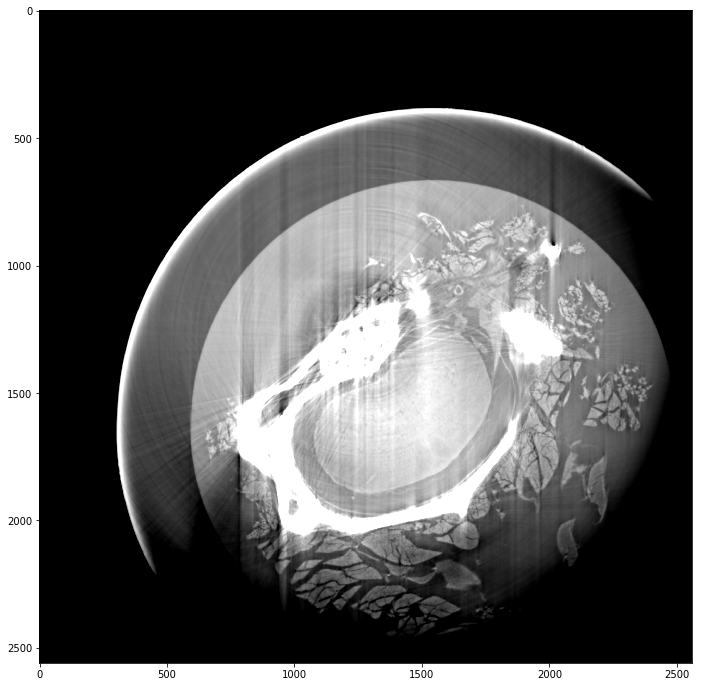

In [61]:
data = imread('/home/makov/diskmnt/big/tomo_data/bukreeva/data_ESRF/slice_Paganin.tif').astype('float32')*1e10
plt.figure(figsize=(12,12))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(data, interpolation='nearest', vmin=-0.1, vmax=0.2, cmap=plt.cm.gray)
# plt.colorbar(orientation='horizontal')
plt.show()

In [101]:
import scipy.ndimage
def my_rc(sino0, level):
    def get_my_b(level):
        t= np.mean(sino0, axis=0)
        gt = scipy.ndimage.filters.gaussian_filter1d(t,level/2.)
        return gt-t
    
    def get_my_a(level):
        my_b = get_my_b(level)
        return np.mean(my_b)/my_b.shape[0]
    
    my_a = get_my_a(level)
    my_b = get_my_b(level)
    
    res = sino0.copy()
    if not level==0:
        res+= sino0*my_a+my_b
    
    return res

A Jupyter Widget

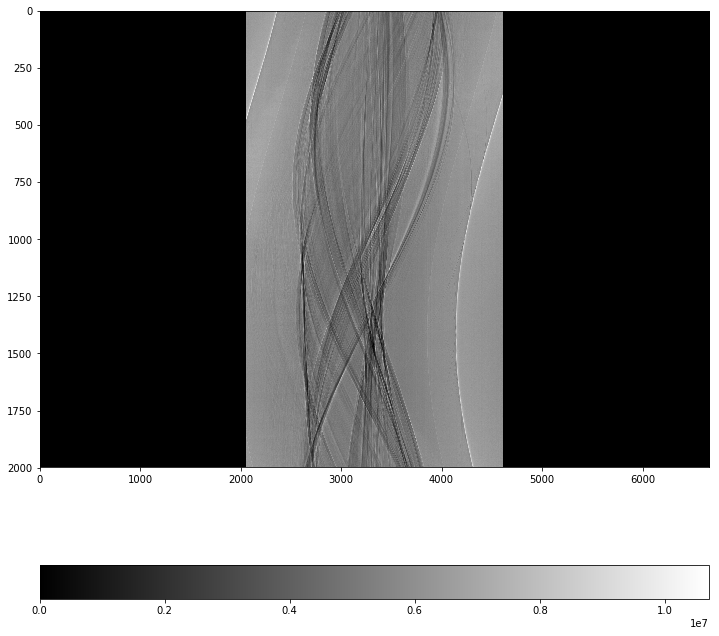

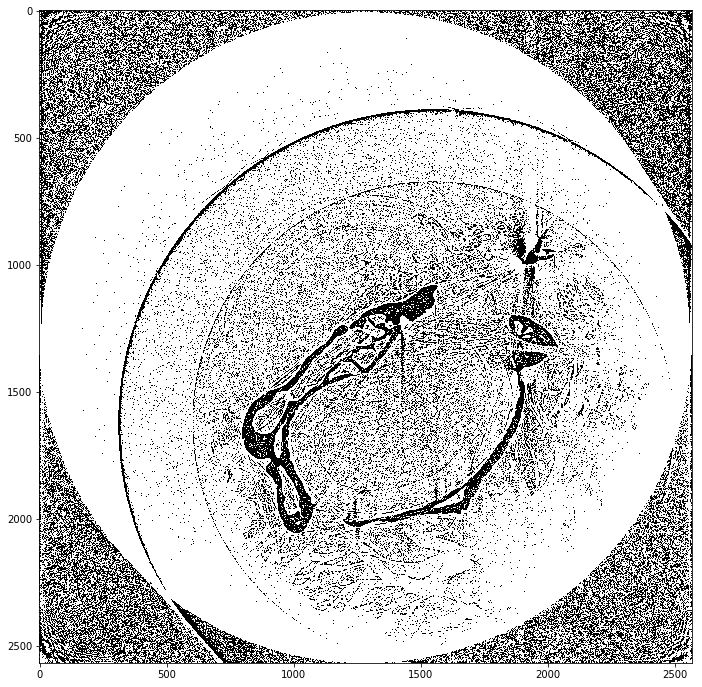

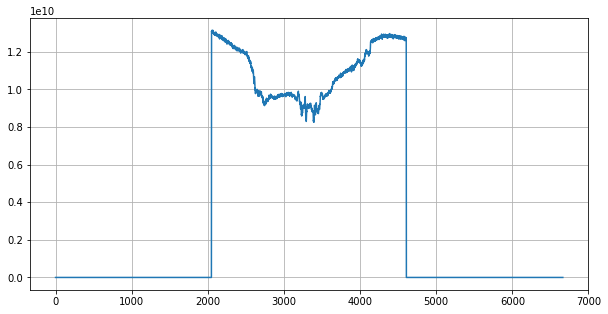

In [254]:
angles_t = angles+angles[1]/3. # to remove spikes in sinogram (delete 0 and 90)
sino = -sinogram_fixed

max_radon=sino.sum(axis=1).max()

MU = rec.sum()*2
X,Y = np.meshgrid(np.arange(rec.shape[0]),np.arange(rec.shape[1]))

X-=rec_pad.shape[0]//2
Y-=rec_pad.shape[1]//2
mask = (X**2+Y**2)<(rec.shape[0]//2)**2-20

for i in log_progress(range(10)):
    rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles_t)
    
    rec_pad*=rec_pad>0
    rec_pad*=mask
    rec_pad[rec_pad>1] = 1
    
#     if rec_pad.sum()>MU:
#         rec_pad = rec_pad/rec_pad.sum()*MU

    sino = astra_build_sinogram(rec_pad, angles_t)
#     sino*=sino>0
#     if i < 150:
#         sino = my_rc(sino, 150-i)
    

    sino = (sino.T/sino.sum(axis=1)*max_radon).T
#   t = sino[:,pad_size:-shift-pad_size]
    sino[:,pad_size:-shift-pad_size] = sinogram
    
# rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)

plt.figure(figsize=(12,12))
plt.imshow(sino, cmap=plt.cm.gray, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.axis('tight')
plt.show()

plt.figure(figsize=(12,12))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec_pad[pad_size:-pad_size,pad_size:-pad_size],
           interpolation='nearest', cmap=plt.cm.gray)
# plt.colorbar(orientation='horizontal')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sino.sum(axis=0))
plt.grid()
plt.show()

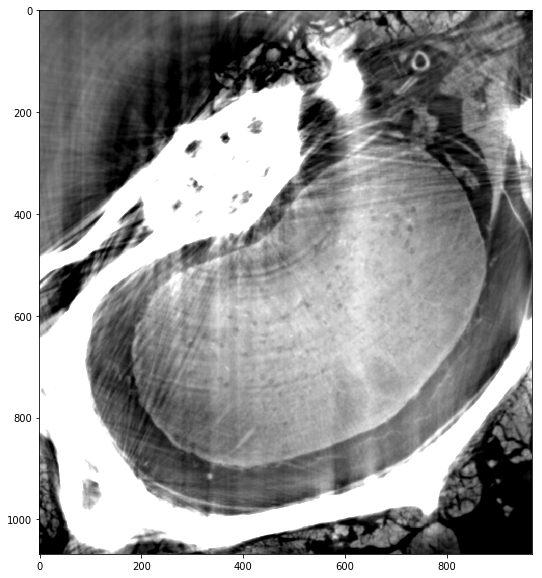

In [127]:
plt.figure(figsize=(10,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec_pad[pad_size+1000:-pad_size-500,pad_size+900:-pad_size-700], vmin=0.00025, vmax=0.0004,
           interpolation='nearest', cmap=plt.cm.gray)
# plt.colorbar(orientation='horizontal')
plt.show()

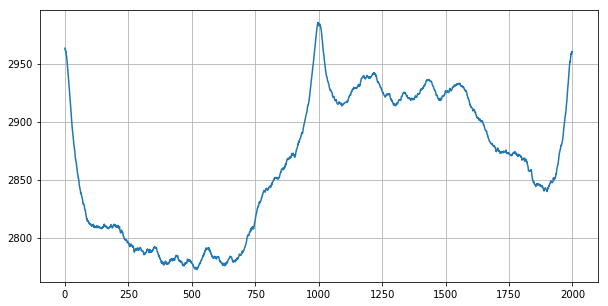

In [104]:
plt.figure(figsize=(10,5))
plt.plot(sino.sum(axis=1))
plt.grid()
plt.show()

In [ ]:

plt.figure(figsize=(12,12))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec_pad, vmax=0.0015,
           interpolation='nearest', cmap=plt.cm.gray)
# plt.colorbar(orientation='horizontal')
plt.show()

plt.figure(figsize=(12,12))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec_pad[pad_size:-pad_size,pad_size:-pad_size], vmax=0.0015,
           interpolation='nearest', cmap=plt.cm.gray)
# plt.colorbar(orientation='horizontal')
plt.show()


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(sino.sum(axis=1))
plt.grid()

In [ ]:
# rec_plot = np.zeros_like(rec_pad)
# rec_plot[150:-150,150:-150] = data
plt.figure(figsize=(10,5))
plt.plot(rec_pad0[:,rec_pad0.shape[1]//2], label='rec_pad0')
plt.plot(rec_pad[:,rec_pad.shape[1]//2], label='rec_pad')
# plt.plot(rec_plot[:,rec_plot.shape[1]//2], label='rec_orig')
plt.grid()
plt.legend(loc=0)
plt.show()

# rec_plot = np.zeros_like(rec_pad)
# rec_plot[150:-150,150:-150] = data
plt.figure(figsize=(10,5))
plt.plot(rec_pad0[rec_pad0.shape[0]//2], label='rec_pad0')
plt.plot(rec_pad[rec_pad.shape[0]//2], label='rec_pad')
# plt.plot(rec_plot[rec_plot.shape[0]//2], label='rec_orig')
plt.grid()
plt.legend(loc=0)
plt.show()

In [ ]:
rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)

plt.figure(figsize=(10,10))
plt.imshow(sino, cmap=plt.cm.gray, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.axis('tight')
plt.show()


plt.figure(figsize=(10,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec_pad, interpolation='nearest', cmap=plt.cm.gray,vmax=1)
plt.colorbar(orientation='horizontal')
plt.show()